# Using Neural Networks and Machine Learning to Predict Toyota's Stock Prices

First, import all libraries needed and define the intervals for training, validation and test (recommended: 80/10/10)

In [13]:
import numpy as np
import pandas as pd
import math
import sklearn
import sklearn.preprocessing
import datetime
import os
import matplotlib.pyplot as plt
import tensorflow as tf

#percentages of the data for each part of the process
valid_set_size_percentage = 10
test_set_size_percentage = 10

### Load the data and preview it

In [14]:
df = pd.read_csv('TM.csv')
df.head(21)

,Date,Open,High,Low,Close,Adj Close,Volume
0,1976-08-18,2.562200,2.562200,2.562200,2.562200,1.532437,19500
1,1976-08-19,2.549578,2.549578,2.549578,2.549578,1.524888,500
2,1976-08-20,2.536956,2.536956,2.536956,2.536956,1.517338,8000
3,1976-08-23,2.461226,2.461226,2.461226,2.461226,1.472045,1000
4,1976-08-24,2.435982,2.435982,2.435982,2.435982,1.456946,7500
5,1976-08-25,2.410740,2.410740,2.410740,2.410740,1.441850,8000
6,1976-08-26,2.410740,2.410740,2.410740,2.410740,1.441850,500
7,1976-08-27,2.499092,2.499092,2.499092,2.499092,1.494692,2500
8,1976-08-30,2.448604,2.448604,2.448604,2.448604,1.464496,40000
9,1976-08-31,2.448604,2.448604,2.448604,2.448604,1.464496,500


### Adjusted close, Volume and Date will not be using in the prediction

In [15]:
df.drop(['Volume'], 1, inplace=True)
df.drop(['Adj Close'], 1, inplace=True)
df.drop(['Date'], 1, inplace=True)

print(list(df.columns.values))

['Open', 'High', 'Low', 'Close']


### Normalize the data and organize it for use by creating a function for the normalization of the data and another function for dividing the data into the training, validating and training segments

In [18]:
#normalization of minimums and maximums of the stocks
def normalization(df):
    min_max_scaler = sklearn.preprocessing.MinMaxScaler()
    df['Open'] = min_max_scaler.fit_transform(df.Open.values.reshape(-1, 1))
    df['High'] = min_max_scaler.fit_transform(df.High.values.reshape(-1, 1))
    df['Low'] = min_max_scaler.fit_transform(df.Low.values.reshape(-1, 1))
    df['Close'] =  min_max_scaler.fit_transform(df.Close.values.reshape(-1, 1))
    return df

#division of the data into the 3 segments
def load_data(stock, seq_len):
    data_raw = stock.as_matrix()
    data = []

    for index in range(len(data_raw) - seq_len):
        data.append(data_raw[index: index + seq_len])

    data = np.array(data);
    valid_set_size = int(np.round(valid_set_size_percentage/100*data.shape[0]));  
    test_set_size = int(np.round(test_set_size_percentage/100*data.shape[0]));
    train_set_size = data.shape[0] - (valid_set_size + test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_valid = data[train_set_size:train_set_size+valid_set_size,:-1,:]
    y_valid = data[train_set_size:train_set_size+valid_set_size,-1,:]
    
    x_test = data[train_set_size+valid_set_size:,:-1,:]
    y_test = data[train_set_size+valid_set_size:,-1,:]

    return [x_train, y_train, x_valid, y_valid, x_test, y_test]


df_normalized = df.copy()
df_normalized = normalization(df_normalized)


seq_len = 20
x_train, y_train, x_valid, y_valid, x_test, y_test = load_data(df_normalized, seq_len)
print('x_train.shape =', x_train.shape)
print('y_train.shape =', y_train.shape)
print('x_valid.shape =', x_valid.shape)
print('y_valid.shape =', y_valid.shape)
print('x_test.shape =', x_test.shape)
print('y_test.shape =', y_test.shape)

x_train.shape = (8495, 19, 4)
y_train.shape = (8495, 19, 4)
x_valid.shape = (1062, 19, 4)
y_valid.shape = (1062, 19, 4)
x_test.shape = (1062, 19, 4)
y_test.shape = (1062, 19, 4)


### Visualize the data after organization

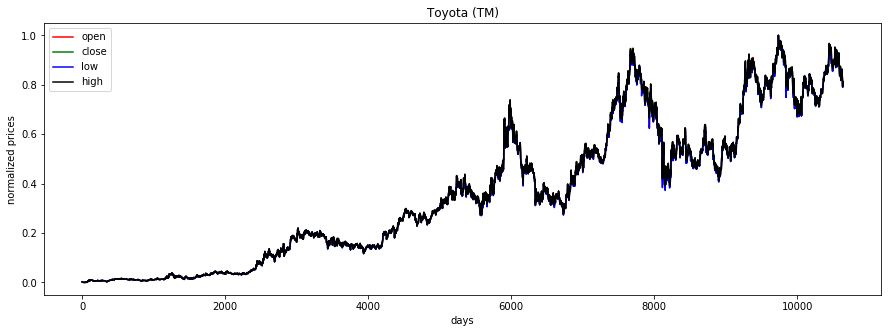

In [19]:
plt.figure(figsize=(15, 5));
plt.plot(df_normalized.Open.values, color='red', label='open')
plt.plot(df_normalized.Close.values, color='green', label='close')
plt.plot(df_normalized.Low.values, color='blue', label='low')
plt.plot(df_normalized.High.values, color='black', label='high')
plt.title('Toyota (TM)')
plt.xlabel('days')
plt.ylabel('normalized prices')
plt.legend(loc='best')
plt.show()

### Define the Model using a RNN model and the parameters for the Neural Network

In [20]:
index_in_epoch = 0;
perm_array = np.arange(x_train.shape[0])
np.random.shuffle(perm_array)

#function for the next set
def get_next_batch(batch_size):
    global index_in_epoch, x_train, perm_array
    start = index_in_epoch
    index_in_epoch += batch_size
    
    if index_in_epoch > x_train.shape[0]:
        np.random.shuffle(perm_array)
        start = 0
        index_in_epoch = batch_size
        
    end = index_in_epoch
    return x_train[perm_array[start:end]], y_train[perm_array[start:end]]

#parameters
n_steps = seq_len-1
n_inputs = 4
n_neurons = 200
n_outputs = 4
n_layers = 2
learning_rate = 0.001
batch_size = 50
n_epochs = 100
train_set_size = x_train.shape[0]
test_set_szie = x_test.shape[0]

tf.reset_default_graph()

x = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_outputs])

#basic RNN cell
layers = [tf.contrib.rnn.BasicRNNCell(num_units = n_neurons, activation = tf.nn.elu)
         for layer in range(n_layers)]

multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)
rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, x, dtype = tf.float32)

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons])
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])
outputs = outputs[:,n_steps-1,:]

loss = tf.reduce_mean(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
training_op = optimizer.minimize(loss)


### Run the Model and gather the data

In [21]:
#grafico
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for iteration in range(int(n_epochs*train_set_size/batch_size)):
        x_batch, y_batch = get_next_batch(batch_size)
        sess.run(training_op, feed_dict={x: x_batch, y: y_batch})
        if iteration % int(5*train_set_size/batch_size) == 0:
            mse_train = loss.eval(feed_dict = {x: x_train, y: y_train})
            mse_valid = loss.eval(feed_dict = {x: x_valid, y: y_valid})
            print('%.2f epochs:: MSE train/valid = %.6f/%.6f'%(iteration*batch_size/train_set_size, mse_train, mse_valid))
            
    y_train_pred = sess.run(outputs, feed_dict={x: x_train})
    y_valid_pred = sess.run(outputs, feed_dict={x: x_valid})
    y_test_pred = sess.run(outputs, feed_dict={x: x_test})
    

0.00 epochs:: MSE train/valid = 0.037222/0.074484
5.00 epochs:: MSE train/valid = 0.000060/0.000122
9.99 epochs:: MSE train/valid = 0.000046/0.000086
14.99 epochs:: MSE train/valid = 0.000063/0.000135
19.99 epochs:: MSE train/valid = 0.000060/0.000122
24.99 epochs:: MSE train/valid = 0.000062/0.000150
29.98 epochs:: MSE train/valid = 0.000088/0.000262
34.98 epochs:: MSE train/valid = 0.000056/0.000098
39.98 epochs:: MSE train/valid = 0.000063/0.000170
44.97 epochs:: MSE train/valid = 0.000046/0.000087
49.97 epochs:: MSE train/valid = 0.000044/0.000079
54.97 epochs:: MSE train/valid = 0.000056/0.000118
59.96 epochs:: MSE train/valid = 0.000056/0.000127
64.96 epochs:: MSE train/valid = 0.000054/0.000138
69.96 epochs:: MSE train/valid = 0.000050/0.000099
74.96 epochs:: MSE train/valid = 0.000434/0.000834
79.95 epochs:: MSE train/valid = 0.000338/0.000676
84.95 epochs:: MSE train/valid = 0.000298/0.000652
89.95 epochs:: MSE train/valid = 0.000236/0.000493
94.94 epochs:: MSE train/valid = 0

### After running the data, plot it and check trends and deviations from the real data

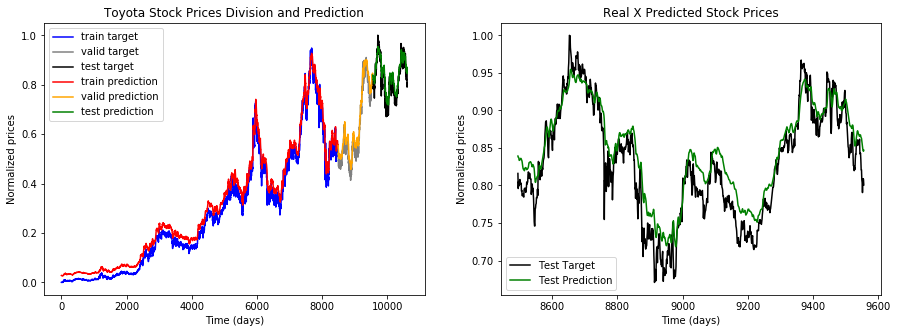

In [25]:
ft = 0# 0=open, 1=close, 2=highest, 3=lowest

#predictions
plt.figure(figsize=(15, 5));
plt.subplot(1,2,1);

plt.plot(np.arange(y_train.shape[0]), y_train[:,ft], color='blue', label='train target')

plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_valid.shape[0]), y_valid[:,ft],
         color='gray', label='valid target')

plt.plot(np.arange(y_train.shape[0]+y_valid.shape[0],
                   y_train.shape[0]+y_test.shape[0]+y_test.shape[0]),
         y_test[:,ft], color='black', label='test target')

plt.plot(np.arange(y_train_pred.shape[0]),y_train_pred[:,ft], color='red',
         label='train prediction')

plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0]+y_valid_pred.shape[0]),
         y_valid_pred[:,ft], color='orange', label='valid prediction')

plt.plot(np.arange(y_train_pred.shape[0]+y_valid_pred.shape[0],
                   y_train_pred.shape[0]+y_valid_pred.shape[0]+y_test_pred.shape[0]),
         y_test_pred[:,ft], color='green', label='test prediction')

plt.title('Toyota Stock Prices Division and Prediction')
plt.xlabel('Time (days)')
plt.ylabel('Normalized prices')
plt.legend(loc='best');


plt.subplot(1,2,2);

plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_test.shape[0]),
        y_test[:,ft], color='black', label='Test Target')

plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0]+y_test_pred.shape[0]),
        y_test_pred[:,ft], color='green', label='Test Prediction')

plt.title('Real X Predicted Stock Prices')
plt.xlabel('Time (days)')
plt.ylabel('Normalized prices')
plt.legend(loc='best');
